# Tutorial: Conversational RAG Agent using InMemoryChatMessageStore

- **Level**: Advanced
- **Time to complete**: 20 minutes
- **Components Used**: [`Agent`](https://docs.haystack.deepset.ai/docs/agent), [`ChatPromptBuilder`](https://docs.haystack.deepset.ai/docs/chatpromptbuilder), [`InMemoryBM25Retriever`](https://docs.haystack.deepset.ai/docs/inmemorybm25retriever) [`OpenAIChatGenerator`](https://docs.haystack.deepset.ai/docs/openaichatgenerator), [`OutputAdapter`](https://docs.haystack.deepset.ai/docs/outputadapter)
- **Experimental Components Used**: [`ChatMessageStore`](https://docs.haystack.deepset.ai/reference/experimental-chatmessage-store-api), [`ChatMessageRetriever`](https://docs.haystack.deepset.ai/reference/experimental-retrievers-api#chatmessageretriever), [`ChatMessageWriter`](https://docs.haystack.deepset.ai/reference/experimental-writers-api)
- **Prerequisites**: You need an [OpenAI API Key](https://platform.openai.com/api-keys)
- **Goal**: After completing this tutorial, you'll have learned how to incorporate a conversational history into a RAG pipeline to enable multi-turn conversations grounded in documents.

## Overview
In this tutorial, you'll first build a simple conversational pipeline using chat components and an LLM. You'll then extend this setup into a conversational RAG pipeline using the Agent component, capable of handling multi-turn interactions over documents.

Along the way, you'll learn how to store, retrieve, and reuse chat history so the system can preserve context across user questions.

**Why is this useful?** By incorporating conversational memory, a RAG system can remember earlier parts of a conversation. This allows users to ask natural follow-up questions without restating context, while the pipeline continues to retrieve relevant information and generate accurate responses based on the full conversation history.

> 🧪 **Beta Feature Notice**:
>
> The **ChatMessageStore** feature is currently in **beta**, available in the [haystack-experimental](https://github.com/deepset-ai/haystack-experimental) repository. We'd love your feedback, join the conversation in [this GitHub discussion](https://github.com/deepset-ai/haystack-experimental/discussions/420) and help us shape this feature!

## Installation

Install Haystack, `haystack-experimental` and `datasets` with pip:

In [1]:
%%bash

pip install -q haystack-ai "haystack-experimental>=0.15.0" datasets

## Enter OpenAI API key

In [2]:
import os
from getpass import getpass

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

Enter OpenAI API key:··········


## Conversational Pipeline

In this section, we build a simple conversational pipeline using the new chat components. The example focuses on enabling multi-turn conversations and shows how session-level chat history is managed using a `chat_history_id`.

### Create a ChatMessage Store

Conversation history is stored as `ChatMessage` objects in an `InMemoryChatMessageStore`. The `ChatMessageRetriever` reads past messages from the store, while the `ChatMessageWriter` appends new messages after each interaction. Together, these components allow the pipeline to persist and reuse chat history across multiple turns.

Import these components from the [haystack-experimental](https://github.com/deepset-ai/haystack-experimental) package:

In [3]:
from haystack_experimental.chat_message_stores.in_memory import InMemoryChatMessageStore
from haystack_experimental.components.retrievers import ChatMessageRetriever
from haystack_experimental.components.writers import ChatMessageWriter

# Chat History components
message_store = InMemoryChatMessageStore()
message_retriever = ChatMessageRetriever(message_store)
message_writer = ChatMessageWriter(message_store)

### Build the Pipeline

Now let's build the conversational pipeline. To understand how conversation history flows through the system, it helps to look at how the components are connected and how messages move between them.

First, we add `ChatPromptBuilder`, `OpenAIChatGenerator`, `ChatMessageRetriever`, `ChatMessageWriter` and `OutputAdapter` components to the pipeline.  

The prompt generated by the `prompt_builder` is first sent to the `message_retriever` as `current_messages`. This allows the new user message to be combined with any previously stored chat history inside the `message_retriever`. If a system message is provided to the `prompt_builder`, `message_retriever` places it at the beginning, followed by the retrieved history and the current user message. The resulting sequence of messages is then passed to the LLM as input.

At the same time, the same prompt is forwarded to the `message_joiner`. After the LLM generates a response, the `message_joiner` combines the original user message with the LLM's reply. This merged set of messages is then sent to the `message_writer` to be stored in the chat history.

In [4]:
from haystack import Pipeline
from haystack.components.builders import ChatPromptBuilder
from haystack.components.converters import OutputAdapter
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.dataclasses import ChatMessage

pipeline = Pipeline()

# components to communicate with an LLM
pipeline.add_component(
    "prompt_builder",
    ChatPromptBuilder(
        template=[
            ChatMessage.from_system("You are a helpful AI assistant that answers users questions."),
            ChatMessage.from_user("{{query}}"),
        ],
        required_variables="*",
    ),
)
pipeline.add_component("llm", OpenAIChatGenerator(model="gpt-4o"))

# components for chat history retrieval and storage
pipeline.add_component("message_retriever", ChatMessageRetriever(message_store))
pipeline.add_component("message_writer", ChatMessageWriter(message_store))
pipeline.add_component(
    "message_joiner", OutputAdapter(template="{{ prompt + replies }}", output_type=list[ChatMessage], unsafe=True)
)

# connections
pipeline.connect("prompt_builder.prompt", "message_retriever.current_messages")
pipeline.connect("prompt_builder.prompt", "message_joiner.prompt")
pipeline.connect("message_retriever.messages", "llm.messages")
pipeline.connect("llm.replies", "message_joiner.replies")
pipeline.connect("message_joiner", "message_writer.messages")

🚅 Components
  - prompt_builder: ChatPromptBuilder
  - llm: OpenAIChatGenerator
  - message_retriever: ChatMessageRetriever
  - message_writer: ChatMessageWriter
  - message_joiner: OutputAdapter
🛤️ Connections
  - prompt_builder.prompt -> message_retriever.current_messages (list[ChatMessage])
  - prompt_builder.prompt -> message_joiner.prompt (list[ChatMessage])
  - llm.replies -> message_joiner.replies (list[ChatMessage])
  - message_retriever.messages -> llm.messages (list[ChatMessage])
  - message_joiner.output -> message_writer.messages (list[ChatMessage])

### Visualize the pipeline

Visualize the pipeline with the [`show()`](https://docs.haystack.deepset.ai/docs/visualizing-pipelines) method to confirm the connections are correct.

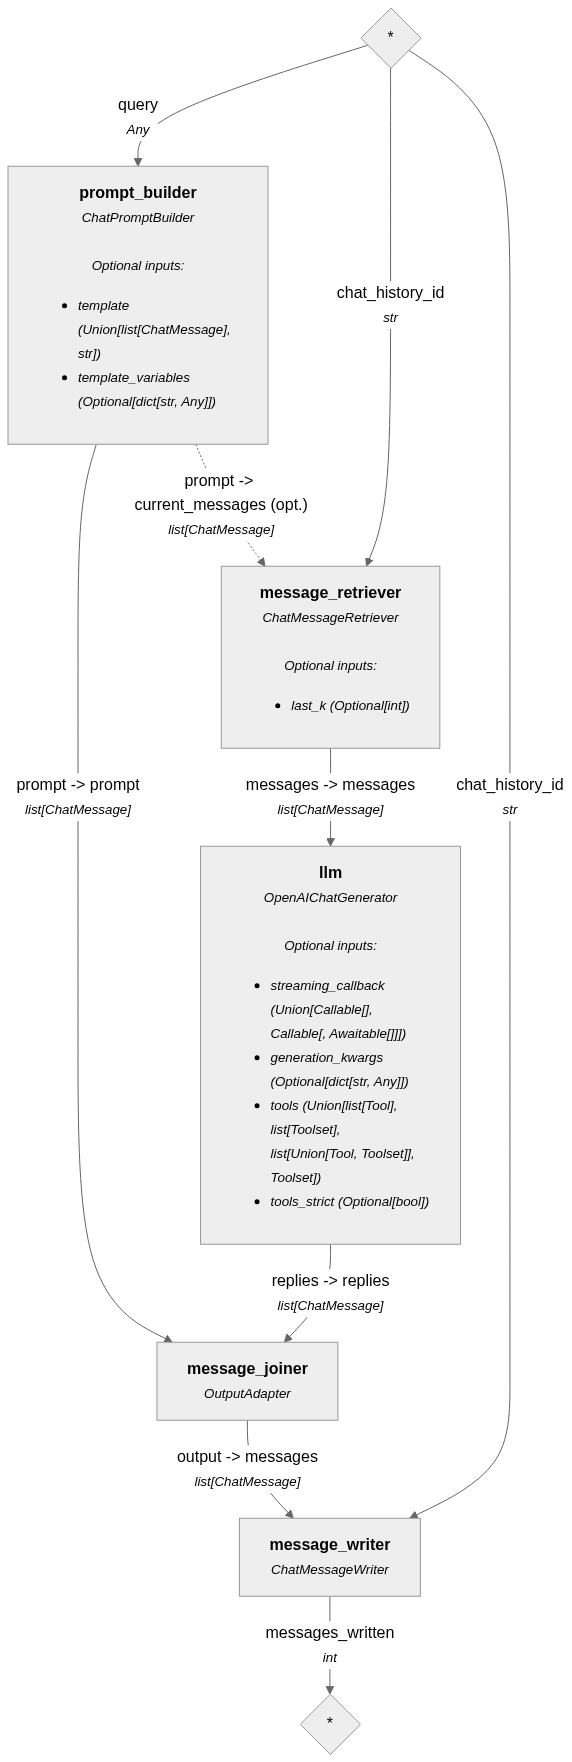

In [ ]:
# pipeline.show()

### Run the Pipeline

- Test the pipeline with some queries.
- Ensure that in every request we add a `chat_history_id` parameter so that we know which conversational history we'd like to retrieve and write to.

Here are example queries you can try:

* *Describe retrieval augmented generation in a few words.*
* *What do people use it for?*

In [5]:
chat_history_id = "user_123_session_1"

while True:
    question = input("Enter your question or Q to exit.\n🧑 ")
    if question == "Q":
        break

    res = pipeline.run(
        data={
            "prompt_builder": {"query": question},
            "message_retriever": {"chat_history_id": chat_history_id},
            "message_writer": {"chat_history_id": chat_history_id},
        },
        include_outputs_from={"llm"},
    )
    print(f'🤖 {res["llm"]["replies"][0].text}')

Enter your question or Q to exit.
🧑 Describe retrieval augmented generation in a few words.
🤖 Combining external information retrieval with generative models to produce contextually relevant responses.
Enter your question or Q to exit.
🧑 What do people use it for?
🤖 People use retrieval-augmented generation (RAG) to improve the accuracy and relevance of generative AI outputs, particularly in applications like question answering, content creation, and customer support. It enhances the model's performance by incorporating up-to-date or domain-specific information from external databases or documents, leading to more informed and context-aware responses.
Enter your question or Q to exit.
🧑 Q


We can also inspect the stored chat history in the `InMemoryChatMessageStore` with the `retrieve_messages` method.

> By default, the `ChatMessage` objects with "system" role are not stored in `ChatMessage` Store. To include system messages, set `skip_system_messages=False` when initializing the `InMemoryChatMessageStore`.

In [6]:
chat_history = message_store.retrieve_messages(chat_history_id=chat_history_id, last_k=None)

for msg in chat_history:
    print(f"ROLE: {msg.role.value}")
    print(f"{msg.text}\n")

ROLE: user
Describe retrieval augmented generation in a few words.

ROLE: assistant
Combining external information retrieval with generative models to produce contextually relevant responses.

ROLE: user
What do people use it for?

ROLE: assistant
People use retrieval-augmented generation (RAG) to improve the accuracy and relevance of generative AI outputs, particularly in applications like question answering, content creation, and customer support. It enhances the model's performance by incorporating up-to-date or domain-specific information from external databases or documents, leading to more informed and context-aware responses.



### Switching to a New Chat Session
- Now we can update the `chat_history_id` to change to a new chat session with an empty chat history

Here are example queries you can try:

* *Who founded deepset?*

In [7]:
# Update the chat history ID
chat_history_id = "user_123_session_2"

while True:
    question = input("Enter your question or Q to exit.\n🧑 ")
    if question == "Q":
        break

    res = pipeline.run(
        data={
            "prompt_builder": {"query": question},
            "message_retriever": {"chat_history_id": chat_history_id},
            "message_writer": {"chat_history_id": chat_history_id},
        },
        include_outputs_from={"llm"},
    )
    print(f'🤖 {res["llm"]["replies"][0].text}')

Enter your question or Q to exit.
🧑 Who founded deepset?
🤖 deepset was founded by Malte Pietsch, Timo Möller, and Milos Rusic. The company is known for its work in natural language processing and the development of the Haystack framework.
Enter your question or Q to exit.
🧑 Q


Now we can fetch the chat history stored under the `"user_123_session_2"` ID.

In [8]:
chat_history = message_store.retrieve_messages(chat_history_id="user_123_session_2", last_k=None)

for msg in chat_history:
    print(f"ROLE: {msg.role.value}")
    print(f"{msg.text}\n")

ROLE: user
Who founded deepset?

ROLE: assistant
deepset was founded by Malte Pietsch, Timo Möller, and Milos Rusic. The company is known for its work in natural language processing and the development of the Haystack framework.



### Other Utility Methods

We have also included other utility methods inside of `InMemoryChatMessageStore` including:
- count_messages
- delete_messages
- delete_all_messages

For more information check out our ChatMessageStore docs at https://docs.haystack.deepset.ai/reference/experimental-chatmessage-store-api

 ## Conversational RAG Agent

In conversational systems, simply prepending the chat history to a new user message is often not sufficient for effective RAG. To retrieve relevant documents, the system needs a way to reinterpret the user's query in the context of the ongoing conversation.

For example, if the first user asks “*What's the first name of Einstein?*” and then follows up with “*Where was he born?*”, the system must understand that “he” refers to Einstein. To retrieve the correct documents, the follow-up query should be reformulated as “Where was Einstein born?”.

This is where the `Agent` component comes in. An agent can use its retrieval tool with a rephrased version of the user's query, ensuring that document retrieval remains accurate across multiple turns.

### Create a Document Store and Index Documents

Create an index with [seven-wonders](https://huggingface.co/datasets/bilgeyucel/seven-wonders) dataset:

In [9]:
from haystack import Document
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.document_stores.in_memory import InMemoryDocumentStore
from datasets import load_dataset

dataset = load_dataset("bilgeyucel/seven-wonders", split="train")
docs = [Document(content=doc["content"], meta=doc["meta"]) for doc in dataset]

document_store = InMemoryDocumentStore()
document_store.write_documents(documents=docs)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


151

### Build the Retrieval Tool

To use the retrieval pipeline with the Agent component, we first create a retrieval pipeline and wrap it with the [PipelineTool](https://docs.haystack.deepset.ai/docs/pipelinetool). The answer generation step is handled by the Agent.

> 💡 For a complete walkthrough on building RAG and retrieval pipelines, see [Creating Your First QA Pipeline with Retrieval-Augmentation Tutorial](https://haystack.deepset.ai/tutorials/27_first_rag_pipeline).

In [10]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.tools import PipelineTool

retrieval_pipeline = Pipeline()

retrieval_pipeline.add_component("doc_retriever", InMemoryBM25Retriever(document_store=document_store, top_k=3))
retrieval_pipeline.add_component(
    "builder",
    PromptBuilder(
        template="""
Supporting documents:
{%- if documents|length > 0 %}
{%- for doc in documents %}
Document [{{ loop.index }}] :
{{ doc.content }}
{% endfor -%}
{%- else %}
No relevant documents found.
{% endif %}
""",
        required_variables="*",
    ),
)

retrieval_pipeline.connect("doc_retriever.documents", "builder.documents")

retrieval_tool = PipelineTool(
    pipeline=retrieval_pipeline,
    name="retrieval_tool",
    description="A tool for fetching information on the seven wonders of the ancient world.",
    input_mapping={"query": ["doc_retriever.query"]},
    output_mapping={"builder.prompt": "retrieval_output"},
)

### Build the Conversational RAG Agent

After creating the retrieval tool, we initialize the `Agent` component with this tool and build a new pipeline. With this setup, the agent can reinterpret incoming user queries based on the conversation history, retrieve the most relevant documents, and generate answers grounded in that retrieved information.

To incorporate conversational context, we add the `ChatMessageRetriever` and `ChatMessageWriter` components to the pipeline alongside the `Agent` like we did in the first pipeline example.



In [11]:
from haystack.components.builders import ChatPromptBuilder
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.agents import Agent
from haystack.components.generators.utils import print_streaming_chunk

conversational_rag_agent = Pipeline()

conversational_rag_agent.add_component(
    "agent",
    Agent(
        system_prompt="""You are a helpful AI assistant that answers users questions grounded in a set supporting documents.
If any questions are asked about the seven wonders, always use the `retrieval_tool` to fetch supporting documents.
Stay concise in your answers.
""",
        chat_generator=OpenAIChatGenerator(model="gpt-4o"),
        tools=[retrieval_tool],
        streaming_callback=print_streaming_chunk,
    ),
)

# components for chat history storage and retrieval
conversational_rag_agent.add_component("message_retriever", ChatMessageRetriever(message_store))
conversational_rag_agent.add_component("message_writer", ChatMessageWriter(message_store))

# connections for the pipeline
conversational_rag_agent.connect("message_retriever.messages", "agent.messages")
conversational_rag_agent.connect("agent.messages", "message_writer")

🚅 Components
  - agent: Agent
  - message_retriever: ChatMessageRetriever
  - message_writer: ChatMessageWriter
🛤️ Connections
  - agent.messages -> message_writer.messages (list[ChatMessage])
  - message_retriever.messages -> agent.messages (list[ChatMessage])

### Let's have a conversation 😀

Now, run the pipeline with the relevant inputs.

Here are some example queries and follow ups you can try:

* *What does Rhodes Statue look like?* - *Who built it?* - *Did he destroy it?*
* *Where is Gardens of Babylon?* - *When was it built?*

In [12]:
chat_history_id = "user_123_session_3"

while True:
    question = input("Enter your question or Q to exit.\n🧑 ")
    if question == "Q":
        break

    conversational_rag_agent.run(
        data={
            "message_retriever": {
                "current_messages": [ChatMessage.from_user(question)],
                "chat_history_id": chat_history_id,
            },
            "message_writer": {"chat_history_id": chat_history_id},
        }
    )
    # No need to print the output since we are streaming it

Enter your question or Q to exit.
🧑 What does Rhodes Statue look like? 
[TOOL CALL]
Tool: retrieval_tool 
Arguments: {"query":"Rhodes Statue description"}

[TOOL RESULT]
{'retrieval_output': "\nSupporting documents:\nDocument [1] :\n[6]\nIn 653, an Arab force under Muslim general Muawiyah I conquered Rhodes, and according to the Chronicle of Theophanes the Confessor,[7] the statue was completely destroyed and the remains sold;[8] this account may be unreliable.[9]\nSince 2008, a series of as-yet-unrealized proposals to build a new Colossus at Rhodes Harbour have been announced, although the actual location of the original monument remains in dispute.[10][11]\n\nSiege of Rhodes[edit]\nMain article: Siege of Rhodes (305–304\xa0BC)\nIn the early fourth century BC, Rhodes, allied with Ptolemy I of Egypt, prevented a mass invasion staged by their common enemy, Antigonus I Monophthalmus.\nIn 304\xa0BC a relief force of ships sent by Ptolemy arrived, and Demetrius (son of Antigonus) and his a

✅ Notice that this time, with the help of query rephrasing, we've built a conversational RAG pipeline that can handle follow-up queries and retrieve the relevant documents.

(_Notebook by [Sebastian Husch Lee](https://www.linkedin.com/in/sebastian-husch-lee) and [Vladimir Blagojevic](https://www.linkedin.com/in/blagojevicvladimir)_)